In [1]:
import os
import sys
from hydromt_sfincs.sfincs import Sfincs

Create grid from scratch

In [2]:
sf = Sfincs()

In [3]:
inp_dict = {"x0": 268650, "y0": 5018550, "dx": 150.0, "dy": 150.0, "nmax": 272, "mmax": 425, "rotation": 0, "crs": 32633}
#update input file based on dictionary
sf.update_input_file(inp_dict=inp_dict)
#create grid
sf.create_grid(grid_type="regular")

Create mask purely based on include- and exclude polygons

In [4]:
from hydromt_sfincs import utils
file_name = "sfincs_coastal//include.pol"

struct = utils.read_geoms(fn=file_name)
gdf_include = utils.polygon2gdf(feats=struct, crs=sf.grid.crs)


In [5]:
file_name = "sfincs_coastal//exclude.pol"
gdf_exclude = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.grid.crs)

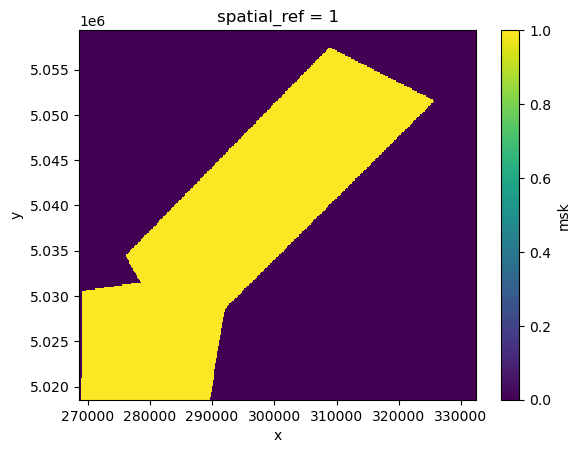

In [6]:
mask = sf.grid.create_mask_active(gdf_include=gdf_include, gdf_exclude=gdf_exclude)
mask.plot.imshow()

Also take into account topobathy information

In [7]:
from hydromt import DataCatalog
from hydromt_sfincs import workflows
data_catalog = DataCatalog() # north Italy

# sf.grid.data.raster.set_crs(sf.grid.crs)
region = sf.grid.mask.raster.box
da_dep1= data_catalog.get_rasterdataset(
    'gebco', variables=['elevtn'], geom=region, buffer=5
)

da_dep2= data_catalog.get_rasterdataset(
    'merit_hydro', variables=['elevtn'], geom=region, buffer=5
)

# List[xr.DataArray]
da_dep = [da_dep1, da_dep2]

In [8]:
# Add depth information to modelgrid
sf.create_dep(bathymetry_sets = da_dep)
sf.update_input_file(inp_dict={"depfile": "sfincs.dep"})


32 gaps outside valid elevation range < 10 km2.
36 regions < 10 km2 dropped.


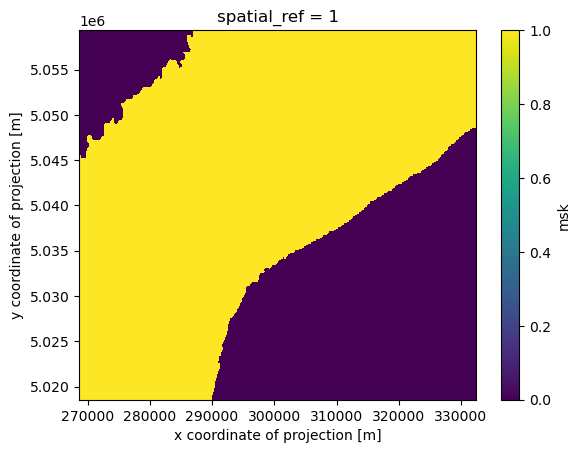

In [9]:
#play around with include, drop_area and fill_area
mask = sf.grid.create_mask_active(elv_min=-5, elv_max=10, fill_area = 10, drop_area = 10, gdf_include=gdf_include)
mask.plot.imshow()

Mask boundaries

In [10]:
file_name = "sfincs_coastal\\bnd_wl.pol"
gdf_wl = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.grid.crs)

file_name = "sfincs_coastal\\bnd_out.pol"
gdf_outflow = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf.grid.crs)

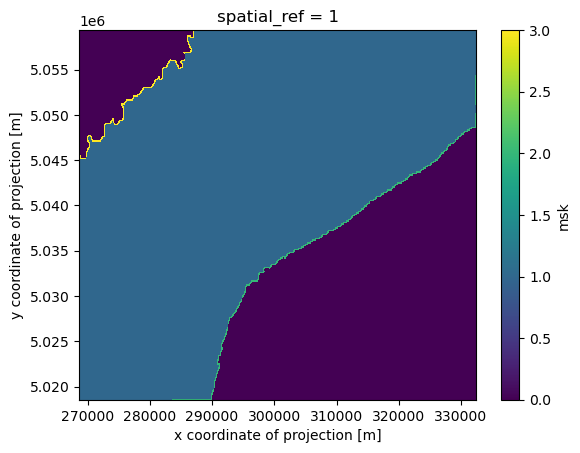

In [11]:
sf.grid.create_mask_bounds(btype="waterlevel",gdf_include=gdf_wl, elv_max = -2)
sf.grid.create_mask_bounds(btype="outflow",gdf_include=gdf_outflow, elv_min = 2)

sf.update_input_file(inp_dict={"indexfile": "sfincs.ind"})
sf.update_input_file(inp_dict={"mskfile": "sfincs.msk"})

sf.grid.mask.plot.imshow()

In [12]:
sf.root = "tmp_example"
sf.write()

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'NoneType'